In [ ]:
import os
from google.colab import drive

drive.mount('/content/drive')
% cd /content/drive/MyDrive/Attack_detection/

In [ ]:
import sys
import math

import pickle
import os
import time

import numpy as np
import pandas as pd

import torch

import matplotlib as mpl

import matplotlib.pyplot as plt
from tqdm import tqdm
from numpy import linalg as LA

from torchvision import transforms
from PIL import Image

from numpy import random

from sklearn.metrics import confusion_matrix, roc_auc_score

import seaborn as sns


% cd / content / drive / MyDrive / Attack_detection / yolov5 / yolov5

from models.experimental import attempt_load
from utils.general import non_max_suppression, check_img_size
from utils.torch_utils import time_synchronized

% cd / content / drive / MyDrive / Attack_detection /
% matplotlib inline

In [ ]:
def calc_iou(box1, box2):
    """
    Calculates the Intersection over Union of two rectangles in shape [xmin, ymin, xmax, ymax]
    """
    xmin, ymin, xmax, ymax = 0, 1, 2, 3
    dx = min(box1[xmax], box2[xmax]) - max(box1[xmin], box2[xmin])
    dy = min(box1[ymax], box2[ymax]) - max(box1[ymin], box2[ymin])
    if dx <= 0 or dy <= 0:
        return 0

    def area(box):
        return (box[xmax] - box[xmin]) * (box[ymax] - box[ymin])

    overlap = dx * dy
    return overlap / (area(box1) + area(box2) - overlap)


def get_pairs(original, segmented, num_objects):
    """
    Returns the pairs of corresponding objects that have the highest IOU
    """
    pairs = []
    original_length = min(num_objects, len(original))
    segmented_length = min(num_objects, len(segmented))
    for i in range(original_length):
        for j in range(segmented_length):
            iou = calc_iou(np.array(original[i]), np.array(segmented[j]))
            pairs.append([i, j, iou])
    good_pairs = {}
    taken_js = []
    for i, j, iou in sorted(pairs, key=lambda x: x[2], reverse=True):
        if i in good_pairs or j in taken_js:
            continue
        good_pairs[i] = [j, iou]
        taken_js.append(j)
    return good_pairs

In [ ]:
# 0: boxes, 1: scores, 2: classes, 3: nums
def diff_outputs_helper(original, segmented, num_objects, threshold):
    """
    Returns the score of a pair of original and segmented given the num of objects and threshold
    """
    boxes, scores, classes, nums = 0, 1, 2, 3

    pairs = get_pairs(original[boxes], segmented[boxes], num_objects)
    new_pairs = []
    pairs_length = min(num_objects, len(pairs))
    available_keys = pairs.keys()
    for i in range(pairs_length):
        if i not in available_keys:  #fix because of get_pairs sort, some keys are missing.
            continue
        j, iou = pairs[i]
        new_pairs.append([
            [i, original[classes][i], original[scores][i]],
            [j, segmented[classes][j], segmented[scores][j]],
            iou])
    score = 0
    num_good_objects = min(num_objects, len(pairs))
    for o, s, iou in new_pairs:
        if o[2] < threshold and s[2] < threshold:
            num_good_objects -= 1
        else:
            score += (o[1] == s[1]) * int(math.pow(abs(o[2] - s[2]), 0.5) < 0.2) * iou
    return score / num_good_objects if num_good_objects > 0 else 0


def create_diffs(clean_inferences, clean_seg_inferences, attacked_inferences, attacked_seg_inferences, threshold=0.3,
                 num_objects=5, idxs=None):
    '''
    difference in images non-segmented,segmented -> (image_idx, avg similarity)
    '''
    #Actually the function that should detect adversarial
    diffs = []
    diffs_attacked = []
    lst = idxs if idxs else range(len(attacked_seg_inferences))
    for i in lst:  # [(img_idx, )]
        diffs.append((i, diff_outputs_helper(clean_inferences[i], clean_seg_inferences[i], num_objects, threshold)))
    for i in lst:
        diffs_attacked.append(
            (i, diff_outputs_helper(attacked_inferences[i], attacked_seg_inferences[i], num_objects, threshold)))
    return [diffs, diffs_attacked]

In [ ]:
def get_predictions(device, model, input_transform, img_src_path, classes, iou_thres=0.6, conf_thres=0.001,
                    num_of_objects=np.inf):
    model.eval()

    img = Image.open(img_src_path).convert('RGB')
    img = input_transform(img).unsqueeze(0)

    curr_shape = img.shape  #[1,c,h,w]
    h = curr_shape[2]
    w = curr_shape[3]
    stride = int(model.stride.max())  # model stride
    imgsz_h_stride = check_img_size(h, s=stride)  # check img_size
    imgsz_w_stride = check_img_size(w, s=stride)  # check img_size

    if imgsz_h_stride != h or imgsz_w_stride != w:
        print(
            "dims need reshaping: " + str(h) + "->" + str(imgsz_h_stride) + " | " + str(w) + "->" + str(imgsz_w_stride))
        print("if dim got bigger, padding with zeros!")
        h_pad_size = imgsz_h_stride - h
        w_pad_size = imgsz_w_stride - w
        '''
        (N,C,H_in,W_in) - > (N,C,H_out,W_out)
        (padding_left , padding_right, padding_top ,padding_bottom )
        H_out=H_in+padding_top+padding_bottom
        W_out=W_in+padding_left+padding_right
        '''
        img = torch.nn.functional.pad(input=img, pad=(w_pad_size, 0, h_pad_size, 0), mode='constant', value=0)
        print("new dims: " + str(img.shape))

    img = img.to(device)

    # Inference
    t1 = time_synchronized()

    pred, train_out = model(img)  # pred inference and training outputs

    # Apply NMS
    pred = non_max_suppression(pred, conf_thres=conf_thres, iou_thres=iou_thres, classes=classes, agnostic=False,
                               multi_label=True)

    t2 = time_synchronized()

    boxes, scores, classes = [], [], []
    # Process detections
    for j, det in enumerate(pred):  # detections per image

        for z, row in enumerate(det):  #boxes,scores,classes in det[1]

            box, score, cls = [row[0].item(), row[1].item(), row[2].item(), row[3].item()], row[4].item(), row[5].item()

            boxes.append(box)
            scores.append(score)
            classes.append(cls)

            if z + 1 == num_of_objects:  #get only num_of_objects at maximum
                break

    return [boxes, scores, classes]

In [ ]:
def img_path(i, clean=True, seg=False, alpha=None):
    """
    This function returns the path of an image
    Arguments:
    i -- the index of the frame as was saved in segmentation notebook
    Keyword arguments:
    clean -- whether to search in clean folder or attacked folder (default True)
    seg -- whether to search for segmented image or not (default False)
    alpha -- the alpha transparency
    """
    loc = "_clean" if clean else "_attacked"
    ext = "_seg" if seg else ""
    t = ";{0}".format(alpha) if alpha else ""
    return dataset_source + "/frame{0}{1}_{2}{3}.png".format(loc, ext, i, t)


def get_all_preds(device, model, input_transform, alpha, classes, iou_thres=0.6, conf_thres=0.001,
                  num_of_objects=np.inf, num_of_images=500):
    """
    Returns all preds for given alpha
    shape per image is [boxes,confs_score,classes]
    """
    ret = []
    idxs = (num_of_images)
    ret.append([get_predictions(device, model, input_transform, img_path(i, clean=True, seg=False, alpha=alpha),
                                classes, iou_thres, conf_thres, num_of_objects) for i in range(idxs)])  # clean
    ret.append([get_predictions(device, model, input_transform, img_path(i, clean=True, seg=True, alpha=alpha), classes,
                                iou_thres, conf_thres, num_of_objects) for i in range(idxs)])  # clean seg
    ret.append([get_predictions(device, model, input_transform, img_path(i, clean=False, seg=False, alpha=alpha),
                                classes, iou_thres, conf_thres, num_of_objects) for i in range(idxs)])  # attacked
    ret.append([get_predictions(device, model, input_transform, img_path(i, clean=False, seg=True, alpha=alpha),
                                classes, iou_thres, conf_thres, num_of_objects) for i in range(idxs)])  # attacked seg
    return ret

In [ ]:

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

weights = './yolov5/yolov5/yolov5x.pt'
model = attempt_load(weights, map_location=device)

dataset_source = './SCNN_attack_output_alphas'

input_transform = transforms.Compose([
    transforms.ToTensor(), ])

alphas = [0.2, 0.25, 0.3, 0.35, 0.4, 0.45, 0.5, 0.55, 0.6, 0.75, 0.9, 1]

num_of_images = 500

object_conf_thres = 0.25

iou_thres = 0.45  # for NMS

num_of_objects = 5

classes_to_filter = None  # filter by class: --class 0, or --class 0 2 3. | None may be problematic, but no need to Filter

run_all_preds = True
if run_all_preds:
    all_inferences = {
        alpha: get_all_preds(device, model, input_transform, alpha, classes_to_filter, iou_thres, object_conf_thres,
                             num_of_objects, num_of_images) for alpha in alphas}
    with open(dataset_source + '/all_inferences.pickle', 'wb') as f:
        pickle.dump(all_inferences, f)
else:
    with open(dataset_source + '/all_inferences.pickle', 'rb') as f:
        all_inferences = pickle.load(f)

clean_i, clean_seg_i, attacked_i, attacked_seg_i = 0, 1, 2, 3







In [ ]:

run_all_inferences_diffs = True
if run_all_inferences_diffs:
    all_inferences_diffs = {}
    for alpha in alphas:
        clean_inferences = all_inferences[alpha][clean_i]
        clean_seg_inferences = all_inferences[alpha][clean_seg_i]
        attacked_inferences = all_inferences[alpha][attacked_i]
        attacked_seg_inferences = all_inferences[alpha][attacked_seg_i]

        print("Starting to create diffs for alpha: " + str(alpha))
        all_inferences_diffs[alpha] = create_diffs(clean_inferences, clean_seg_inferences, attacked_inferences,
                                                   attacked_seg_inferences, object_conf_thres, num_of_objects)
        print("finished diffs for alpha: " + str(alpha))

    with open(dataset_source + '/all_inferences_diffs.pickle', 'wb') as f:
        pickle.dump(all_inferences_diffs, f)
else:
    with open(dataset_source + '/all_inferences_diffs.pickle', 'rb') as f:
        all_inferences_diffs = pickle.load(f)



In [ ]:
def plot_cm(cm):
    group_names = ['True Negative', 'False Positive', 'False Negative', 'True Positive']
    group_counts = ["{0:0.0f}".format(value) for value in cm.flatten()]
    labels = [f"{v1}\n{v3}\n\n{v2}" for (v1, v3), v2 in
              zip([x.split() for x in group_names], group_counts)]
    labels = np.asarray(labels).reshape(2, 2)
    fig = sns.heatmap(cm, annot=labels, fmt='', cmap='Blues')
    plt.xlabel("Predicted", fontsize=12)
    plt.ylabel("True", fontsize=12)
    plt.show(fig)


def get_metrics_and_plot(rand_mean_times, start_valid_idx, end_valid_idx, training_set_sizes, all_inferences_diffs,
                         alpha=0.5, plot=False):
    print("Calculating metrics for alpha: " + str(alpha))
    valid_size = end_valid_idx - start_valid_idx
    diffs, diffs_attacked = all_inferences_diffs[alpha]
    thresholds = []
    for i in training_set_sizes:
        res = []
        for j in range(rand_mean_times):
            tmp = np.random.choice([y for (x, y) in diffs], i).mean()
            res.append(tmp)
        thresholds.append(sum(res) / len(res))

    all_metrics = []
    new_scores = [y for (x, y) in diffs[start_valid_idx:end_valid_idx]] + [y for (x, y) in diffs_attacked[
                                                                                           start_valid_idx:end_valid_idx]]
    new_scores = np.array(new_scores)
    y_true = np.array([0] * valid_size + [1] * valid_size)  # 0 is benign, 1 is attacked
    y_preds = []
    for threshold in thresholds:
        y_pred = np.array([int(pred < threshold) for pred in new_scores])
        y_preds.append(y_pred)
        cm = confusion_matrix(y_true, y_pred)
        tn = cm[0][0]
        fn = cm[1][0]
        tp = cm[1][1]
        fp = cm[0][1]
        #plot_cm(cm)
        accuracy = (tn + tp) / (tn + fp + fn + tp) if tn + tp > 0 else 0
        false_discovery_rate = fp / (tp + fp) if fp > 0 else 0
        negative_predictive_value = tn / (tn + fn) if tn > 0 else 0
        true_negative_rate = tn / (tn + fp) if tn > 0 else 0
        false_negative_rate = fn / (tp + fn) if fn > 0 else 0
        recall = tp / (tp + fn) if tp > 0 else 0
        precision = tp / (tp + fp) if tp > 0 else 0
        f1 = 2 * (precision * recall) / (precision + recall) if precision + recall > 0 else 0
        roc_auc = roc_auc_score(y_true, y_pred)
        metrics = [threshold, tp, fp, tn, fn, accuracy, false_discovery_rate, negative_predictive_value,
                   true_negative_rate, false_negative_rate, recall, precision, f1, roc_auc]
        all_metrics.append(metrics)
    all_metrics = np.array(all_metrics)
    cols = ["Threshold", "TP", "FP", "TN", "FN",
            "Accuracy", "False Discovery Rate", "Negative Predictive Value", "True Negative Rate",
            "False Negative Rate", "Recall", "Precision", "F1", "ROC AUC"]
    df = pd.DataFrame(all_metrics, columns=cols)
    print(df)

    if plot == True:
        mpl.rcParams.update(mpl.rcParamsDefault)
        fig, axs = plt.subplots(3, 3, figsize=(11, 10))
        colors = ['#1B5C7C', '#1B7C58', '#AF5F9D',
                  '#F6931C', '#1CF6CA', '#1C5DF6',
                  '#F61C78', '#446B41', '#1CE40E']
        i = 0
        for col in ["TP", "FP", "TN", "FN",
                    "Accuracy", "Recall", "Precision", "F1", "ROC AUC"]:
            ax = axs[i // 3, i % 3]
            df[col].plot(color=colors[i], ax=ax)
            ax.set_title(col)
            i += 1
        plt.show()
        return new_scores, y_true




In [ ]:
start_valid_idx = 0

end_valid_idx = 500

rand_mean_times = 3  #number of times to do random choice of size training_set_size to create threshold, averaging this number of times to reduce noises

training_set_sizes = [50, 100, 150, 200, 250, 300, 350, 400]

plot = True

for alpha in alphas:
    y_preds, y_true = get_metrics_and_plot(rand_mean_times, start_valid_idx, end_valid_idx, training_set_sizes,
                                           all_inferences_diffs, alpha, plot)

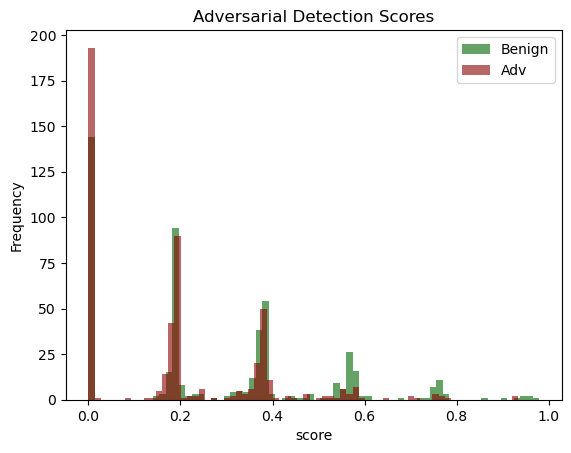

In [ ]:
plt.title('Adversarial Detection Scores')
plt.hist(y_preds[:500], color='darkgreen', bins=70, alpha=0.6)
plt.hist(y_preds[500:], color='darkred', bins=70, alpha=0.6)
plt.legend(['Benign', 'Adv'])
plt.xlabel('score')
plt.ylabel('Frequency')
plt.show()

# Quantitative results

In [ ]:
from sklearn.metrics import roc_auc_score, precision_recall_curve, auc

precision, recall, thresholds = precision_recall_curve(y_true, y_preds)
print(f'AUCROC {roc_auc_score(1 - y_true, y_preds)}')

AUCROC 0.601448


In [ ]:
benign_scores = y_preds[:500]
adv_scores = y_preds[500:]

In [ ]:

def search_thers(score, level):
    step = 0.000001
    val = 0
    eps = 0.01
    while True:
        TNR = (score >= val).sum().item() / len(score)
        if TNR <= level + eps and TNR >= level - eps:
            return val
        elif TNR > level:
            val += step
        else:
            val = val - step
            step = step * 0.1
    return val

In [ ]:
thres95 = search_thers(benign_scores, 0.95)
TNR95 = (adv_scores < thres95).sum().item() / len(adv_scores)
print(TNR95)

In [ ]:
thres95

In [ ]:
(benign_scores > thres95).sum().item() / len(benign_scores)
#should be ~0.95